In [1]:
import os
import sys
import numpy as np
import pandas as pd
import scipy as sp
import scipy.sparse
import h5py

import tensorflow as tf
import matplotlib.pyplot as plt
import scanpy as sc

# add parent folder path to load our package
import sys; sys.path.insert(0, '..')

physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    # Invalid device or cannot modify virtual devices once initialized.
    pass

# Load data

In [2]:
with h5py.File('dogma_cite_asap.h5', 'r') as f:
    print(f.keys())
    ADT_names = np.array(f['ADT_names'], dtype='S32').astype(str)
    gene_names = np.array(f['gene_names'], dtype='S32').astype(str)
    
    # Count matrices of three modalities: X for genes, Y for ADT, and Z for peaks.
    X = sp.sparse.csc_matrix(
        (np.array(f['RNA.data'], dtype=np.float32), 
         np.array(f['RNA.indices'], dtype=np.int32),
         np.array(f['RNA.indptr'], dtype=np.int32)
        ), 
        shape = np.array(f['RNA.shape'], dtype=np.int32)).tocsc().astype(np.float32)
    Y = np.array(f['ADT'], dtype=np.float32)
    cell_types = np.array(f['cell_types'], dtype='S32').astype(str)
    
    # The covariate matrix, the last column is the ids of datasets
    batches = np.array(f['batches'], dtype=np.float32)
    
    # The indices of features that are observed in each dataset.
    id_X_cite = np.array(f['id_X_cite'], dtype=np.int32)
    id_Y_cite = np.array(f['id_Y_cite'], dtype=np.int32)
    id_Y_asap = np.array(f['id_Y_asap'], dtype=np.int32)
    
    # The sample size
    sample_sizes = np.array(f['sample_sizes'], dtype=np.int32)

# Preprocess the ADT data
Y = np.log(Y/np.sum(Y, axis=1, keepdims=True)*1e4+1.)
data = Y

# Subset the data, only use CITE-seq and ASAP-seq datasets for illustration.
batches = batches[sample_sizes[0]:]
data = data[sample_sizes[0]:]
data_raw = data.copy()
sample_sizes = sample_sizes[1:]


# Here all the proteins are measured for the two datasets
# so id_Y_cite = id_Y_asap with length 227
dim_input_arr = np.array([len(ADT_names)])

# The masks indicate missing pattern for the whole datasets.
masks_raw = np.zeros_like(data, dtype=np.float32)


# We randomly remove 10% of entries in each dataset to be missing
# Each row corresponds to a cell, and each column corresponds to a feature.
# If the dataset is large, one can also provide a mask matrix with shape (num_datasets, num_features)
# along with a variable `id_datasets` to reduce memory usages.
# -1 means missing and 0 means observed.
id_Y_cite_val = np.random.choice(id_Y_cite, int(0.1*len(id_Y_cite)), replace=False)
id_Y_asap_val = np.random.choice(id_Y_asap, int(0.1*len(id_Y_asap)), replace=False)

masks = masks_raw.copy()
masks[:sample_sizes[0], id_Y_cite_val] = -1
masks[sample_sizes[0]:, id_Y_asap_val] = -1
data = data * (masks != -1)
masks = tf.convert_to_tensor(masks, dtype=tf.float32)

# data and masks have shape [sum(sample_sizes), sum(dim_input_arr)]
print('Sample sizes: {}. Feature sizes: {}.'.format(sample_sizes, dim_input_arr))

<KeysViewHDF5 ['ADT', 'ADT_names', 'RNA.data', 'RNA.indices', 'RNA.indptr', 'RNA.shape', 'batches', 'cell_ids', 'cell_types', 'gene_names', 'id_X_cite', 'id_X_dogma', 'id_Y_asap', 'id_Y_cite', 'id_Y_dogma', 'id_Z_asap', 'id_Z_dogma', 'peak_names', 'peaks.data', 'peaks.indices', 'peaks.indptr', 'peaks.shape', 'sample_sizes']>
Sample sizes: [8689 8535]. Feature sizes: [227].


# Set up config for model training

In [3]:
import scVAEIT
print(scVAEIT.__version__)

from scVAEIT import VAEIT

path_root = 'result/'

config = {
    # Dimension of input features for [ADT]
    'dim_input_arr': dim_input_arr,

    # Blocks for [ADT]
    'dim_block': dim_input_arr, # input dimension of blocks
    'dist_block':['NB'], # distributions of blocks
    'dim_block_enc':np.array([64]), # dimension of first layer of the encoder
    'dim_block_dec':np.array([64]), # dimension of first layer of the decoder
    'dim_block_embed':np.array([64]), # mask embedding dimension

    # Internal network structure
    'dimensions':[32], # dimension of latent layers of encoder; the reversed is used for decoder
    'dim_latent':8, # the latent dimension bewteen the encoder and decoder

    # Weights
    'beta_unobs':.9, # weight for masked out observation; weight for observerd values will be 1-beta_unobs.

    # Masking probability
    "p_feat" : 0.5, # probablity of randomly masking out an entry
}

batches_cate = batches
batches_cont = None

model = VAEIT(config, data, masks, None, batches_cate, batches_cont)

0.2.0
namespace(beta_kl=2.0, beta_reverse=0.2, beta_modal=array([1.], dtype=float32), p_modal=None, uni_block_names=array(['M-0'], dtype='<U23'), block_names=array(['M-0'], dtype='<U23'), dist_block=array(['NB'], dtype='<U2'), dim_block=array([227]), dim_block_enc=array([64], dtype=int32), dim_block_dec=array([64], dtype=int32), skip_conn=False, max_vals=<tf.Tensor: shape=(227,), dtype=float32, numpy=
array([9.0543, 9.0543, 9.0543, 9.0543, 9.0543, 9.0543, 9.0543, 9.0543,
       9.0543, 9.0543, 9.0543, 9.0543, 9.0543, 9.0543, 9.0543, 9.0543,
       9.0543, 9.0543, 9.0543, 9.0543, 9.0543, 9.0543, 9.0543, 9.0543,
       9.0543, 9.0543, 9.0543, 9.0543, 9.0543, 9.0543, 9.0543, 9.0543,
       9.0543, 9.0543, 9.0543, 9.0543, 9.0543, 9.0543, 9.0543, 9.0543,
       9.0543, 9.0543, 9.0543, 9.0543, 9.0543, 9.0543, 9.0543, 9.0543,
       9.0543, 9.0543, 9.0543, 9.0543, 9.0543, 9.0543, 9.0543, 9.0543,
       9.0543, 9.0543, 9.0543, 9.0543, 9.0543, 9.0543, 9.0543, 9.0543,
       9.0543, 9.0543, 9.05

In [4]:
# Here we only train for 300 epochs for illustration purpose
hist = model.train(
        num_epoch=100, batch_size=256, save_every_epoch=50,
        verbose=True, checkpoint_dir=path_root+'checkpoint/')

Deleting old log directory at result/checkpoint/
Train - Start of epoch 1


2024-02-22 08:56:23.123185: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


68/68 [==============================] - 4s 63ms/step - Reconstructed Loss: 183.3626
Epoch 1, Time elapsed: 0.07 minutes
          total, obs_M-0, unobs_M-0,      kl
train :  190.76,   44.77,  140.09,    5.90
Train - Start of epoch 2
68/68 [==============================] - 3s 46ms/step - Reconstructed Loss: 153.9803
Epoch 2, Time elapsed: 0.12 minutes
          total, obs_M-0, unobs_M-0,      kl
train :  154.86,   36.87,  116.26,    1.73
Train - Start of epoch 3
68/68 [==============================] - 3s 47ms/step - Reconstructed Loss: 149.4455
Epoch 3, Time elapsed: 0.18 minutes
          total, obs_M-0, unobs_M-0,      kl
train :  149.72,   35.85,  112.83,    1.04
Train - Start of epoch 4
68/68 [==============================] - 3s 47ms/step - Reconstructed Loss: 145.4858
Epoch 4, Time elapsed: 0.23 minutes
          total, obs_M-0, unobs_M-0,      kl
train :  147.23,   35.40,  111.09,    0.74
Train - Start of epoch 5
68/68 [==============================] - 3s 46ms/step - Reconstr

We can visualize the training loss. It flucuates since we argument the data with random masking, which also provides regularization against overfitting.
One may continue training until the loss gets stablized.

Text(0, 0.5, 'Trianing loss')

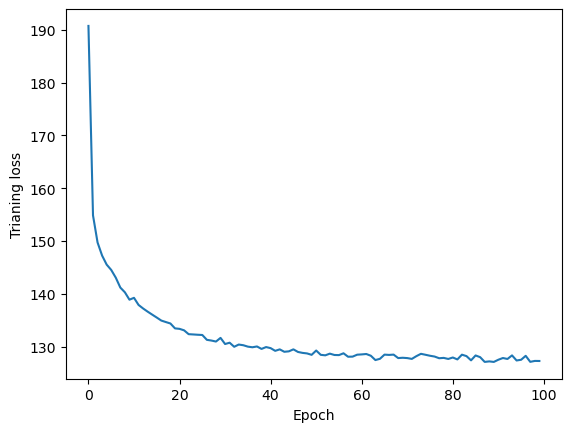

In [5]:
plt.plot(hist['train']['total'])
plt.xlabel('Epoch')
plt.ylabel('Trianing loss')

We can load the trained model:

```python
# load the model and ensure it is loaded successfully
checkpoint = tf.train.Checkpoint(net=model.vae)
n_ckpt = 2
status = checkpoint.restore(path_root+'checkpoint/ckpt-{}'.format(n_ckpt))
model.vae(tf.zeros((1,np.sum(model.vae.config.dim_input_arr))),
          tf.zeros((1,np.sum(model.vae.config.dim_input_arr))),
          tf.zeros((1,np.sum(model.batches.shape[1]))), L=1, training=False)
print(status)
```

# Inspect imputation results

In [6]:
denoised_data = model.get_denoised_data()

Text(0, 0.5, 'Imputed')

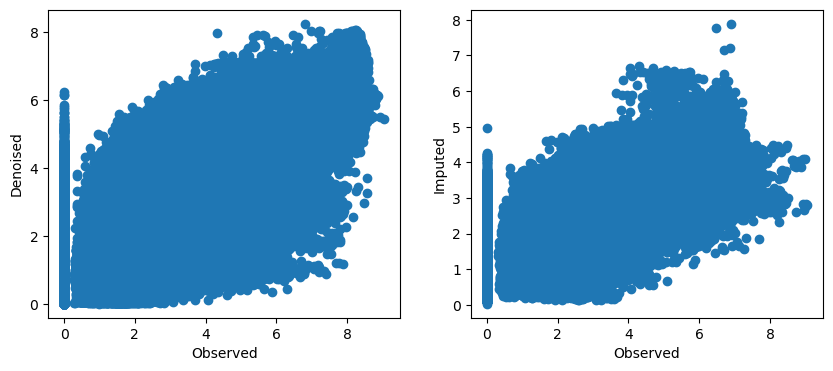

In [7]:
fig, axes = plt.subplots(1,2,figsize=(10,4))
axes[0].scatter(
    data_raw[masks==0],
    denoised_data[masks==0]
    )
axes[0].set_xlabel('Observed')
axes[0].set_ylabel('Denoised')

axes[1].scatter(
    data_raw[(masks_raw==0)&(masks==-1)],
    denoised_data[(masks_raw==0)&(masks==-1)]
    )
axes[1].set_xlabel('Observed')
axes[1].set_ylabel('Imputed')